In [1]:
import pandas as pd
import os
import numpy as np
from numpy import sqrt
import time
from time import gmtime, strftime
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from pathlib import Path

## Constants

In [3]:
# used to distinguish whether jupyter notebook is part of gitlab repo,
# and whether plots/charts/dataframes should be exported and where to
def is_testing_env():
    dir_names = os.getcwd().split(os.sep)
    return not(dir_names[-1] == 'michal_salasek' and dir_names[-2] == 'playground')

TESTING = is_testing_env()

data_relative_path = './data/' if TESTING else '../../data/'
ratings_path = os.path.abspath(data_relative_path + 'user_ratings.csv')

matrices_export_path = os.path.abspath('../../app/db')
ADD_TIMESTAMP = TESTING

# column names for convenience
ITEM = 'BGGId'
GAME = ITEM
USER = 'Username'
RATING = 'Rating'

SHOW = TESTING  # print info, charts etc.

CUTOFF_THRESHOLD = 10
k_latent_factors = 2
n_epochs = 30
learning_rate = 0.005
_lambda = 0.02
n_epochs_per_RMSE = 1  # how often should we compute RMSE (once every three epochs etc.)
chunk_size = 32 * 32
epoch_improvement_threshold = 0.005 # improvement in RMSE of validation set being less than `value` will result in early stopping
EARLY_STOP = True # apply early stopping

## Data processing

In [4]:
# for each Username and board game, keep only the last rating (if a user has rated a game multiple times)

def keep_last_rating(df):
    df = df.drop_duplicates(['Username', 'BGGId'], keep='last')
    return df

In [5]:
# remove users with less than `threshold` ratings
# remove games with less than `threshold` ratings
def drop_less_than_n(df, col, threshold):
    return df[df[col].map(df[col].value_counts()) >= threshold]

In [6]:
def get_processed_dataframe(threshold = CUTOFF_THRESHOLD):
    users_threshold = threshold
    games_threshold = threshold
    ratings = pd.read_csv(ratings_path)
    ratings = keep_last_rating(ratings)
    ratings = drop_less_than_n(ratings, 'Username', users_threshold)
    ratings = drop_less_than_n(ratings, 'BGGId', games_threshold)
    ratings['Rating'] = ratings['Rating'].astype('float32')
    return ratings

In [7]:
df = get_processed_dataframe()

In [8]:
if SHOW:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18340230 entries, 0 to 18942214
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   BGGId     int64  
 1   Rating    float32
 2   Username  object 
dtypes: float32(1), int64(1), object(1)
memory usage: 489.7+ MB
None


In [10]:
unique_games = df['BGGId'].unique()
unique_users = df['Username'].unique()

if SHOW:
    rows = len(unique_users)
    cols = len(unique_games)
    print(f'rows (=users): {rows}')
    print(f'cols (=games): {cols}')
    print(f'number of cells = {rows} x {cols} = {rows*cols}')

rows (=users): 224557
cols (=games): 21919
number of cells = 224557 x 21919 = 4922064883


In [11]:
def get_occurrence(df, col):
    return df.groupby([col])[col].count().sort_values(ascending=False)

def get_user_occurrence(df):
    return get_occurrence(df, USER)

def get_game_occurrence(df):
    return get_occurrence(df, ITEM)

In [13]:
def plot_barchart(series, title, y_label='game', head=True):

    # print top 10 labels (usernames / BGGId's)
    labels = series.head(10) if head else series.tail(10)
    print(labels.index.tolist())
    
    n_items = len(series)
    
    x = np.arange(n_items)
    y = series.values
    
    fig, ax = plt.subplots()
    plt.title(title + f'_{n_items}')
#     plt.xlabel('# of ratings')
    plt.ylabel(f'# of ratings for given {y_label}')
    plt.bar(x, y)


In [14]:
# > split all data into training+validation and test set (80/20)
# > split the training+validation set into training and validation set (80/20 or 75/25)

# we use 'BGGId' column as 'stratify' for train_test_split to get a rating for every game
# that way we get proportionally many ratings for game 'X' in train / validation / test set
# the same can be done for 'Username'

def train_val_test_split(df, stratify_col=None):    
    train_val_size = 0.8
    test_size = 1 - train_val_size
    stratify = df[[stratify_col]] if stratify_col else None
    X_train_val, X_test = train_test_split(df, train_size=train_val_size, test_size=test_size, stratify=stratify)

    train_size = 0.8
    val_size = 1 - train_size
    
    stratify = X_train_val[[stratify_col]] if stratify_col else None
    X_train, X_val = train_test_split(X_train_val, train_size=train_size, test_size=val_size, stratify=stratify)
    
    return [X_train, X_val, X_test]

X_train, X_val, X_test = train_val_test_split(df, GAME)

[30549, 822, 13, 68448, 36218, 9209, 178900, 167791, 173346, 40692]
[30549, 822, 13, 68448, 36218, 9209, 178900, 167791, 173346, 40692]
[30549, 822, 13, 68448, 36218, 9209, 178900, 167791, 173346, 40692]
[235695, 211693, 204541, 196220, 151070, 228370, 36415, 171500, 290500, 207203]
[204541, 260037, 207203, 211693, 171500, 235695, 251253, 36415, 284111, 332420]
[332420, 326408, 281257, 290500, 36415, 235695, 228370, 207203, 171500, 151070]


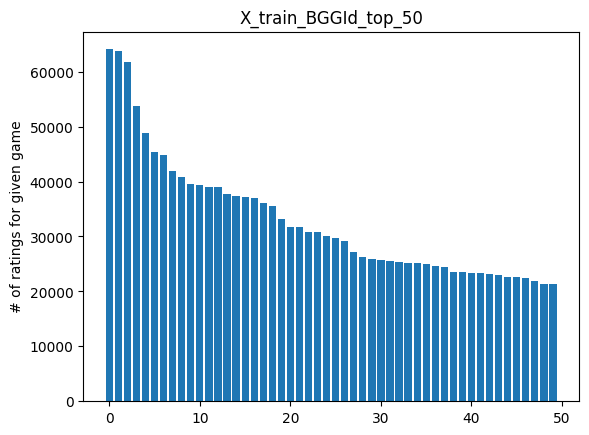

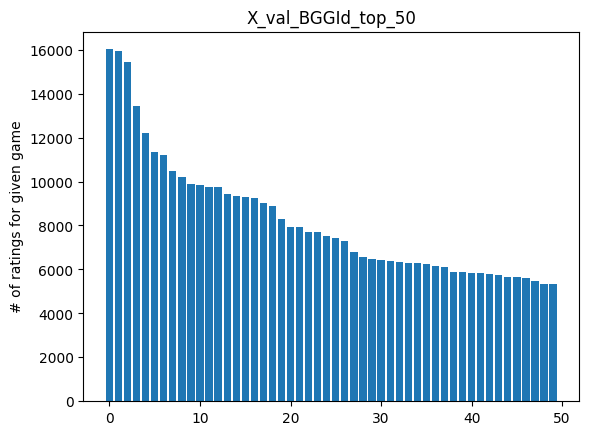

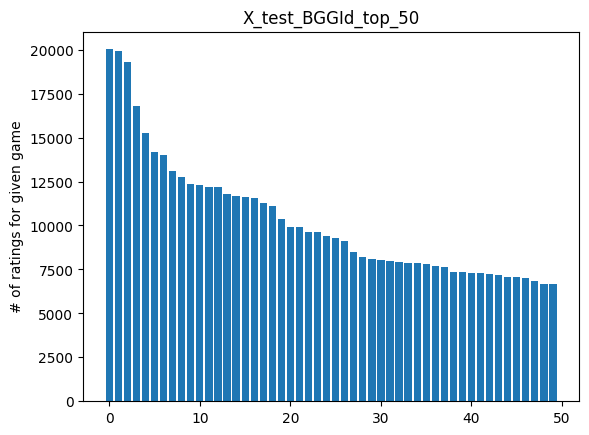

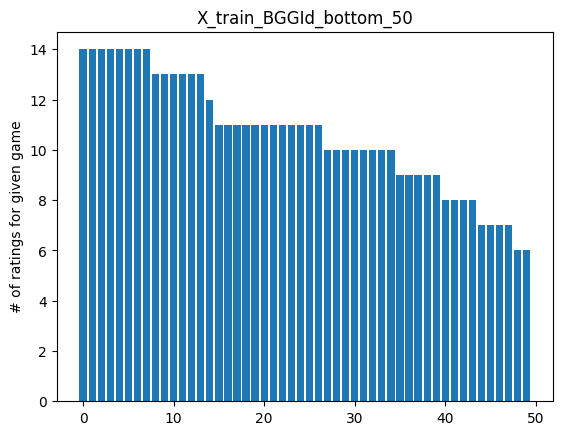

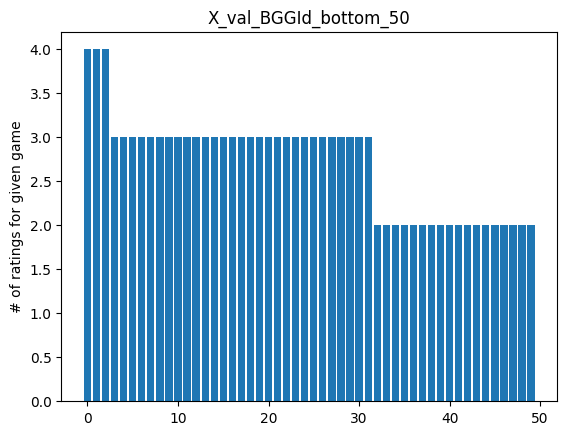

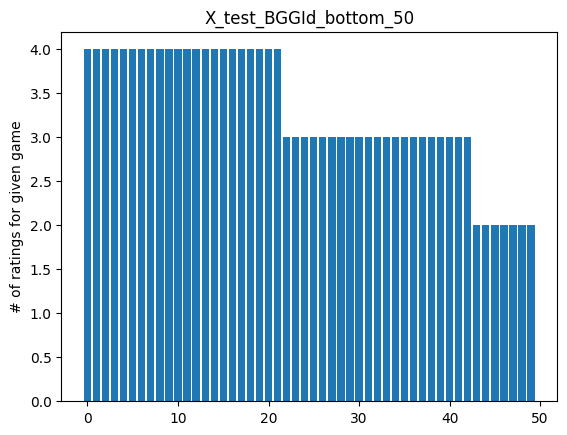

In [15]:
# just a quick verification that data is split properly (as described above)
def plot_charts_for_data_split(X_train, X_val, X_test, occurrence=GAME):
    
    if occurrence == GAME:
        X_train_occ = get_game_occurrence(X_train)
        X_val_occ = get_game_occurrence(X_val)
        X_test_occ = get_game_occurrence(X_test)
    else:
        X_train_occ = get_user_occurrence(X_train)
        X_val_occ = get_user_occurrence(X_val)
        X_test_occ = get_user_occurrence(X_test)

    plot_barchart(X_train_occ.head(50), f"X_train_{occurrence}_top")
    plot_barchart(X_val_occ.head(50), f"X_val_{occurrence}_top")
    plot_barchart(X_test_occ.head(50), f"X_test_{occurrence}_top")
    
    plot_barchart(X_train_occ.tail(50), f"X_train_{occurrence}_bottom", head=False)
    plot_barchart(X_val_occ.tail(50), f"X_val_{occurrence}_bottom", head=False)
    plot_barchart(X_test_occ.tail(50), f"X_test_{occurrence}_bottom", head=False)

if SHOW:
    plot_charts_for_data_split(X_train, X_val, X_test)


In [16]:
def get_unique_count(df, col):
    return len(df[col].unique())

def print_unique_count(X_train, X_val, X_test, col):
    X_train_unique = get_unique_count(X_train, col)
    X_val_unique = get_unique_count(X_val, col)
    X_test_unique = get_unique_count(X_test, col)
    
    print(f'X_train_unique_{col}: {X_train_unique}')
    print(f'X_val_unique_{col}: {X_val_unique}')
    print(f'X_test_unique_{col}: {X_test_unique}')

if SHOW:
    print(f'[ total unique games: {get_unique_count(df, GAME)} ]')
    print_unique_count(X_train, X_val, X_test, GAME)
    print()
    print(f'[ total unique users: {get_unique_count(df, USER)} ]')
    print_unique_count(X_train, X_val, X_test, USER)
    
    

[ total unique games: 21919 ]
X_train_unique_BGGId: 21919
X_val_unique_BGGId: 21919
X_test_unique_BGGId: 21919

[ total unique users: 224557 ]
X_train_unique_Username: 224556
X_val_unique_Username: 218454
X_test_unique_Username: 221431


In [17]:
if SHOW:
    print("\n" + 20 * "=" + "[ X_train ]" + 20 * "=")
    print(X_train.info())
    print("\n" + 20 * "=" + "[ X_val ]" + 20 * "=")
    print(X_val.info())
    print("\n" + 20 * "=" + "[ X_test ]" + 20 * "=")
    print(X_test.info())


====================[ X_train ]====================
<class 'pandas.core.frame.DataFrame'>
Index: 11737747 entries, 11151635 to 12887007
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   BGGId     int64  
 1   Rating    float32
 2   Username  object 
dtypes: float32(1), int64(1), object(1)
memory usage: 313.4+ MB
None

====================[ X_val ]====================
<class 'pandas.core.frame.DataFrame'>
Index: 2934437 entries, 16855041 to 14701807
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   BGGId     int64  
 1   Rating    float32
 2   Username  object 
dtypes: float32(1), int64(1), object(1)
memory usage: 78.4+ MB
None

====================[ X_test ]====================
<class 'pandas.core.frame.DataFrame'>
Index: 3668046 entries, 9426181 to 13334458
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   BGGId     int64  
 1   Rating    float32
 2   Username  object 
dtypes: float32(1

In [18]:
def add_timestamp(name):
    return name + "_" + strftime("%Y-%m-%d_%H-%M-%S", gmtime())


def timer_function(func):
    def wrap_func(*args, **kwargs):
        t1 = time.time()
        result = func(*args, **kwargs)
        t2 = time.time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [19]:
def save_df(df, name, method='pickle', timestamp=True):
    
    if timestamp:
        name = add_timestamp(name)
    
    if method == 'h5':
        store = pd.HDFStore('store.h5')
        store[name] = df
    
    elif method == 'pickle':
        df.to_pickle(f'{name}.pkl')
    
    
def load_df(name, method='pickle'):
    
    if method == 'h5':
        store = pd.HDFStore('store.h5')
        return store[name]
    
    if method == 'pickle':
        return pd.read_pickle(f'{name}.pkl')
    
def load_dfs():
    return [load_df('user_factors'), load_df('item_factors')]
    
# save DFs into .pkl files so that they can be loaded for the endpoint
def save_dfs(P, Q, add_timestamp=ADD_TIMESTAMP):
    save_df(P, 'user_factors', 'pickle', add_timestamp)
    save_df(Q, 'item_factors', 'pickle', add_timestamp)
    
def save_dfs_2(P, Q, UB, IB, add_timestamp=ADD_TIMESTAMP):
    save_df(P, 'user_factors_with_global_effects', 'pickle', add_timestamp)
    save_df(Q, 'item_factors_with_global_effects', 'pickle', add_timestamp)
    save_df(UB, 'user_biases', 'pickle', add_timestamp)
    save_df(IB, 'item_biases', 'pickle', add_timestamp)

## Training

In [20]:
# if we wanna consider global effects, add variables for user/item bias and global mean later:
# return mean + user_bias + item_bias + np.dot(user_factors, item_factors.T)
def rating_prediction(user_factors, item_factors):
    return np.dot(user_factors, item_factors.T)

# currently not used due to this being applicable to a single user/item_factors vector

In [21]:
def RMSE(P, Q, ratings):
    user_ids = ratings['Username']
    item_ids = ratings['BGGId']

    user_factors = P.loc[user_ids].values
    item_factors = Q.loc[item_ids].values

    actual_ratings = ratings['Rating'].values
    predicted_ratings = np.einsum('ij, ij->i', user_factors, item_factors)
    
    error = mean_squared_error(predicted_ratings, actual_ratings)
    return sqrt(error)

In [22]:
# the rule for early stopping probably could be adjusted based on number of epochs, e.g.:
# a) if there are 100 epochs, it might make sense to only evaluate after e.g. every 5 epochs,
#    and if the validation error has increased, stop training
# b) if there are only < 10 epochs, we might wanna evaluate validation error after every epoch,
#    and stop training after validation error has increased once/twice/... in a row
def should_early_stop(validation_errors):
    if len(validation_errors) < 2:
        return False
    error_increased = validation_errors[-1] > validation_errors[-2]
    improvement_value = validation_errors[-2] - validation_errors[-1]
    return error_increased or improvement_value < epoch_improvement_threshold


def plot_errors(train_error, val_error, n_epochs):
    
    if len(train_error) < 2:
        return
    
    x = [i for i in range(len(train_error))]
    
    # plot lines
    plt.plot(x, train_error, label = "train_error")
    plt.plot(x, val_error, label = "val_error")
    plt.ylabel(f'RMSE')
    plt.xlabel(f'n-th RMSE computation')
    plt.legend()
    plt.show()

In [23]:
def print_training_info():
    print()
    print(20*"=" + '[ training summary ]' + 20*"=")
    print()
    print(f'k latent factors: {k_latent_factors}')
    print(f'n epochs: {n_epochs}')
    print(f'chunk size: {chunk_size}')
    print(f'learning rate: {learning_rate}')
    print(f'regularization coefficient: {_lambda}')
    print(f'RMSE frequence: once every {n_epochs_per_RMSE} epochs ... how often is RMSE calculated')
    print()

In [24]:
def split_dataframe(df, chunk_size): 
    chunks = list()
    num_chunks = math.ceil(len(df) / chunk_size)
    for i in range(num_chunks):
        chunks.append(df.iloc[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [25]:
def get_initialized_matrix(unique_elements, col_prefix, k_latent_factors):
    # users_factors matrix of dimensions U x k
    matrix_data = 3 * np.random.rand(len(unique_elements), k_latent_factors)
    matrix = pd.DataFrame(data = matrix_data, 
                  index = unique_elements,
                  columns = [f'{col_prefix}_{i+1}' for i in range(k_latent_factors)])
    return matrix

In [26]:
# uses minibatch
def fit(X_train, X_val, unique_users, unique_items):
    
    # users_factors matrix of dimensions U x k
    P = get_initialized_matrix(unique_users, 'user_feature', k_latent_factors)
    
    # items_factors matrix of dimensions I x k
    Q = get_initialized_matrix(unique_items, 'item_feature', k_latent_factors)

    train_error = []
    val_error = []
    early_stop_flag = False

    if SHOW:
        print_training_info()
    
    for epoch in range(n_epochs):
        
        if SHOW:
            print()
            print(10*"=" + f'[ epoch #{epoch+1} ]' + 10*"=")
            print()
        
        epoch_start = time.time()
        batch = 0
        chunks = split_dataframe(X_train, chunk_size)
        
        for chunk in chunks:
            
            batch += 1
            if SHOW and batch % (len(chunks) // 5) == 1:
                print(f'batch #{batch}')
            
            user_ids = chunk['Username']
            item_ids = chunk['BGGId']
            
            user_factors = P.loc[user_ids].values
            item_factors = Q.loc[item_ids].values
            
            actual_rating = chunk['Rating'].values
            # pair-wise multiplication + sum = dot product for user_factors[i], item_factors[i]
            predicted_rating = np.einsum('ij, ij->i', user_factors, item_factors)
            
            error = actual_rating - predicted_rating
            
            # allow to multiply shape of (chunks, k_latent_factors) /=factors/ with (chunks,) /=error/
            # error[0] value multiplies each element of user/item_factors[0] (u1, u2, u3)
            P_err = item_factors * error[:, None]
            Q_err = user_factors * error[:, None]

            P_gradient = learning_rate * (P_err - _lambda * user_factors)
            Q_gradient = learning_rate * (Q_err - _lambda * item_factors)
            
            
            P.loc[user_ids] += P_gradient
            Q.loc[item_ids] += Q_gradient
        
        # either every n-th epoch (starting at first) or when it's the last epoch
        should_compute_RMSE = (epoch % n_epochs_per_RMSE == 0) or (epoch == n_epochs - 1)
        if should_compute_RMSE and EARLY_STOP:
            
            train_rmse = RMSE(P, Q, X_train)
            val_rmse = RMSE(P, Q, X_val)

            train_error.append(train_rmse)
            val_error.append(val_rmse)
        
            if SHOW:
                print()
                print(f'X_train RMSE: {train_rmse}')
                print(f'X_val RMSE: {val_rmse}')
            
            # if the validation error has increased, it might be a sign of overfitting
            early_stop_flag = should_early_stop(val_error)
        
        epoch_end = time.time()
        if SHOW:
            print()
            print(f'epoch took {epoch_end - epoch_start} seconds')
    
        if early_stop_flag:
            if SHOW:
                print()
                print(f'Early stopping after {epoch+1} epochs')
            break
    
    if SHOW:
        plot_errors(train_error, val_error, epoch+1)
        
    return [P, Q]

In [28]:
start = time.time()

P, Q = fit(X_train, X_val, unique_users, unique_games)

end = time.time()

if SHOW:
    print(f'{end - start} seconds; X_train size: {len(X_train)}, X_val size: {len(X_val)}')
    print(f'X_test error: {RMSE(P, Q, X_test)}')

In [159]:
save_dfs(P, Q)

In [29]:
def RMSE_2(P, Q, UB, IB, global_mean, ratings):
    user_ids = ratings['Username']
    item_ids = ratings['BGGId']

    user_factors = P.loc[user_ids].values
    item_factors = Q.loc[item_ids].values

    user_biases = UB.loc[user_ids].values
    item_biases = IB.loc[item_ids].values

    global_effects = global_mean + user_biases + item_biases
     # pair-wise multiplication + sum = dot product for user_factors[i], item_factors[i]
    user_item_interaction = np.einsum('ij, ij->i', user_factors, item_factors)

    actual_ratings = ratings['Rating'].values
    predicted_ratings = global_effects + user_item_interaction
    
    error = mean_squared_error(predicted_ratings, actual_ratings)
    return sqrt(error)

In [30]:
# global effects + latent factors
def fit_2(X_train, X_val, unique_users, unique_items):
    
    # users_factors matrix of dimensions U x k
    P = get_initialized_matrix(unique_users, 'user_feature', k_latent_factors)
    
    # items_factors matrix of dimensions I x k
    Q = get_initialized_matrix(unique_items, 'item_feature', k_latent_factors)
    
    # user/item biases
#     UB = get_initialized_matrix(unique_users, 'bias', 1)
#     IB = get_initialized_matrix(unique_items, 'bias', 1)
    
    UB_data = 3 * np.random.rand(len(unique_users))
    UB = pd.Series(
        index=unique_users,
        data=UB_data,
    )
    
    IB_data = 3 * np.random.rand(len(unique_items))
    IB = pd.Series(
        index=unique_items,
        data=IB_data,
    )
    
    global_mean = compute_global_mean(X_train)
    
    train_error = []
    val_error = []
    early_stop_flag = False
    _learning_rate = learning_rate
    
    if SHOW:
        print_training_info()
    
    for epoch in range(n_epochs):
        
        if epoch % 1 == 0:
            _learning_rate -= 0.001
        
        if SHOW:
            print()
            print(10*"=" + f'[ epoch #{epoch+1} ]' + 10*"=")
            print()
        
        epoch_start = time.time()
        batch = 0
        chunks = split_dataframe(X_train, chunk_size)
        
        for chunk in chunks:
            
            batch += 1
            if SHOW and batch % (len(chunks) // 5) == 1:
                print(f'batch #{batch}')
            
            user_ids = chunk['Username']
            item_ids = chunk['BGGId']
            
            user_factors = P.loc[user_ids].values
            item_factors = Q.loc[item_ids].values
            
            user_biases = UB.loc[user_ids].values
            item_biases = IB.loc[item_ids].values
            
            global_effects = global_mean + user_biases + item_biases
            
             # pair-wise multiplication + sum = dot product for user_factors[i], item_factors[i]
            user_item_interaction = np.einsum('ij, ij->i', user_factors, item_factors)
            
            actual_rating = chunk['Rating'].values
            predicted_rating = global_effects + user_item_interaction
            error = actual_rating - predicted_rating
            
            # allow to multiply shape of (chunks, k_latent_factors) /=factors/ with (chunks,) /=error/
            # error[0] value multiplies each element of user/item_factors[0] (u1, u2, u3)
            P_err = item_factors * error[:, None]
            Q_err = user_factors * error[:, None]

            P_gradient = _learning_rate * (P_err - _lambda * user_factors)
            Q_gradient = _learning_rate * (Q_err - _lambda * item_factors)
            
            P.loc[user_ids] += P_gradient
            Q.loc[item_ids] += Q_gradient
            
            UB_gradient = _learning_rate * (error - _lambda * user_biases)
            IB_gradient = _learning_rate * (error - _lambda * item_biases)
            
            UB.loc[user_ids] += UB_gradient
            IB.loc[item_ids] += IB_gradient
        
        # either every n-th epoch (starting at first) or when it's the last epoch
        should_compute_RMSE = (epoch % n_epochs_per_RMSE == 0) or (epoch == n_epochs - 1)
        if should_compute_RMSE and EARLY_STOP:
            
            train_rmse = RMSE_2(P, Q, UB, IB, global_mean, X_train)
            val_rmse = RMSE_2(P, Q, UB, IB, global_mean, X_val)

            train_error.append(train_rmse)
            val_error.append(val_rmse)
        
            if SHOW:
                print()
                print(f'X_train RMSE: {train_rmse}')
                print(f'X_val RMSE: {val_rmse}')
            
            # if the validation error has increased, it might be a sign of overfitting
            early_stop_flag = should_early_stop(val_error)
        
        epoch_end = time.time()
        if SHOW:
            print()
            print(f'epoch took {epoch_end - epoch_start} seconds')
    
        if early_stop_flag:
            if SHOW:
                print()
                print(f'Early stopping after {epoch+1} epochs')
            break
    
    if SHOW:
        plot_errors(train_error, val_error, epoch+1)
        
    return [P, Q, UB, IB]

In [31]:
start = time.time()

P, Q, UB, IB = fit_2(X_train, X_val, unique_users, unique_games)

end = time.time()

if SHOW:
    print(f'{end - start} seconds; X_train size: {len(X_train)}, X_val size: {len(X_val)}')
    print(f'X_test error: {RMSE_2(P, Q, UB, IB, global_mean, X_test)}')

In [ ]:
# 1.196 RMSE (3 factors, learning rate = 0.005)
# 1.211 RMSE (5 factors, learning rate = 0.01, lambda = 0.02)
# 1.205 (5 factors, rate = 0.01 - lowered by 0.001 for every epoch, lambda = 0.2)
# 1.196 (3 factors, rate = 0.01 - lowered by 0.001 for every epoch, lambda = 0.2)

In [219]:
save_dfs_2(P, Q, UB, IB)

In [38]:
def get_games():
    path_prefix = './data/'
    games_path = os.path.abspath(path_prefix + 'games_cleaned.csv')
    games = pd.read_csv(games_path)
    games = games.set_index('BGGId')
    return games

In [39]:
games = get_games()
games.head()

,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
BGGId,,,,,,,,,,,,,,,,,,,,,
1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,14.366667,...,21926,21926,0,1,0,0,0,0,0,0
2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,NaN,...,21926,21926,0,1,0,0,0,0,0,0
3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,9.307692,...,21926,21926,0,1,0,0,0,0,0,0
4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.23129,2,4,13.000000,...,21926,21926,0,0,0,0,0,0,0,0
5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.33583,2,6,11.410256,...,21926,21926,0,1,0,0,0,0,0,0


In [36]:
games = get_games()

def best_ranked_game_ids(k=20):
    return games.head(k).index.values

def most_rated_game_ids(k=20):
    return get_game_occurrence(df).head(k).index.values

def oldest_game_ids(k=20):
    return games.sort_values(by='YearPublished').head(k).index.values

def newest_game_ids(k=20):
    return games.sort_values(by='YearPublished', ascending=False).head(k).index.values

def get_game_names(game_ids):
    return games.loc[game_ids]['Name'].values

def get_game_labels(game_ids, col):
    return games.loc[game_ids][col].values

In [34]:
# P, Q = load_dfs()

In [37]:
def show_2d_plot(game_ids, label='Name', show_games_info=False, figure_name=None):
    game_coords = Q.loc[game_ids]
    x = game_coords['item_feature_1'].values
    y = game_coords['item_feature_2'].values

    game_labels = get_game_labels(game_ids, label)
    info_cols = ['Name', 'Description']
    
    if show_games_info:
        print(games[info_cols].loc[game_ids])

    plt.figure(figsize=(12, 12), dpi=120)
    plt.scatter(x, y)

    for i, label in enumerate(game_labels):
        plt.annotate(label, (x[i], y[i]))
    
    plt.xlabel('Factor 1')
    plt.ylabel('Factor 2')
    
    if figure_name:
        plt.savefig(f'{figure_name}.png')

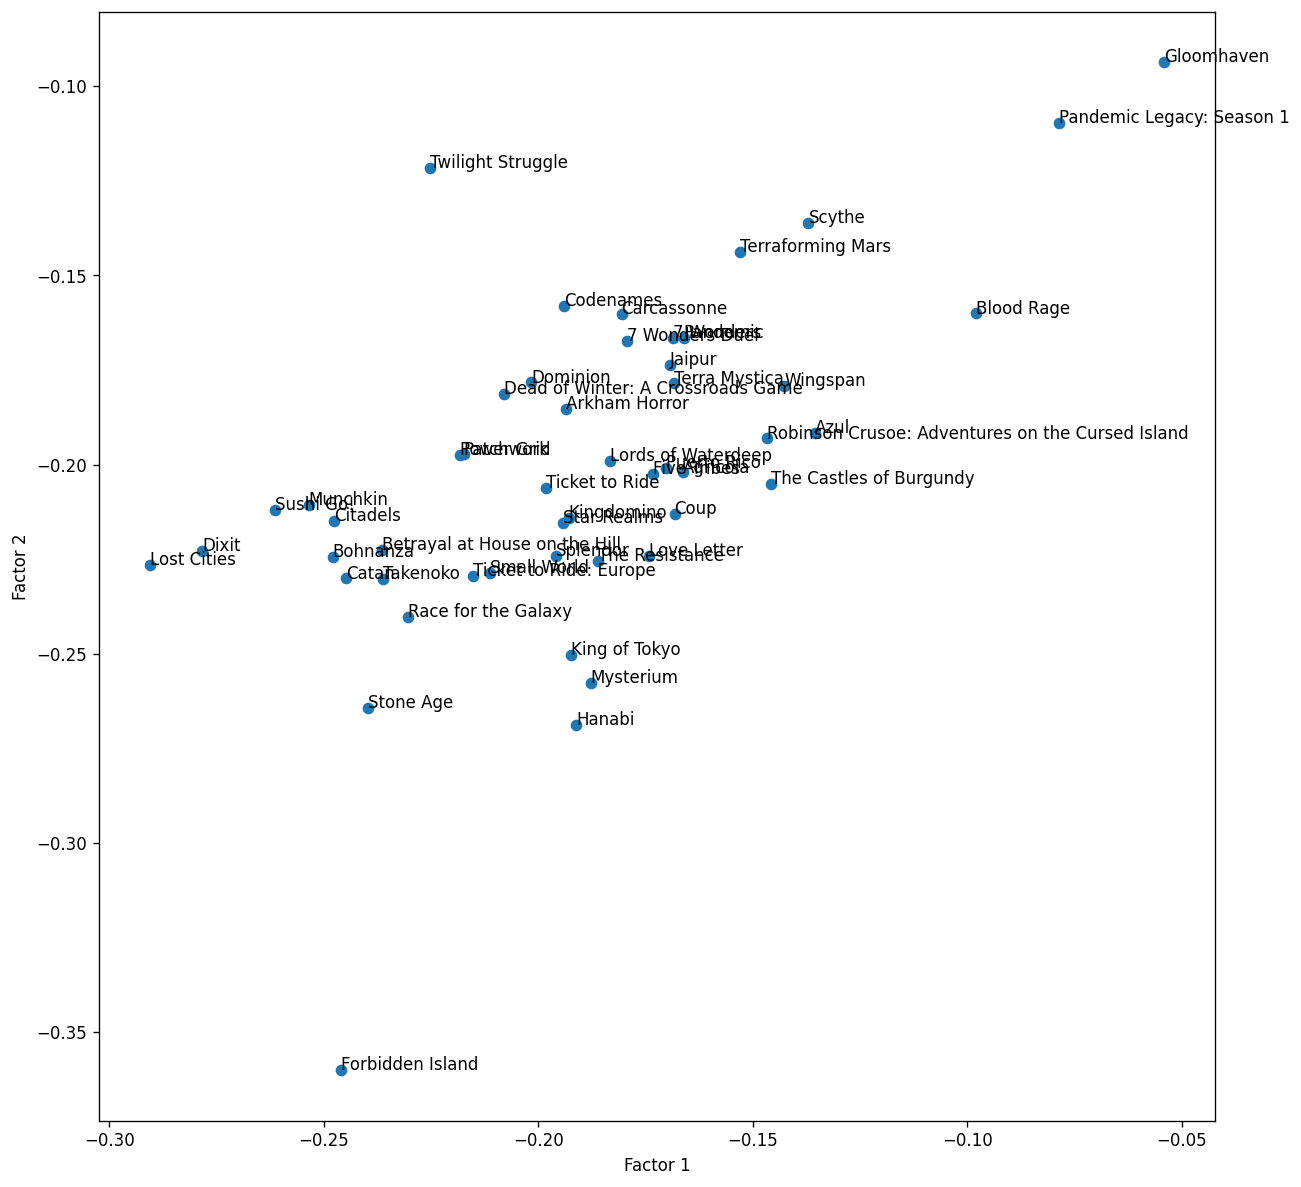

In [283]:
game_ids_1 = most_rated_game_ids(50)
game_ids_2 = best_ranked_game_ids(0)
game_ids = np.unique(np.append(game_ids_1, game_ids_2))

show_2d_plot(game_ids)
# show_2d_plot(game_ids, label='YearPublished')

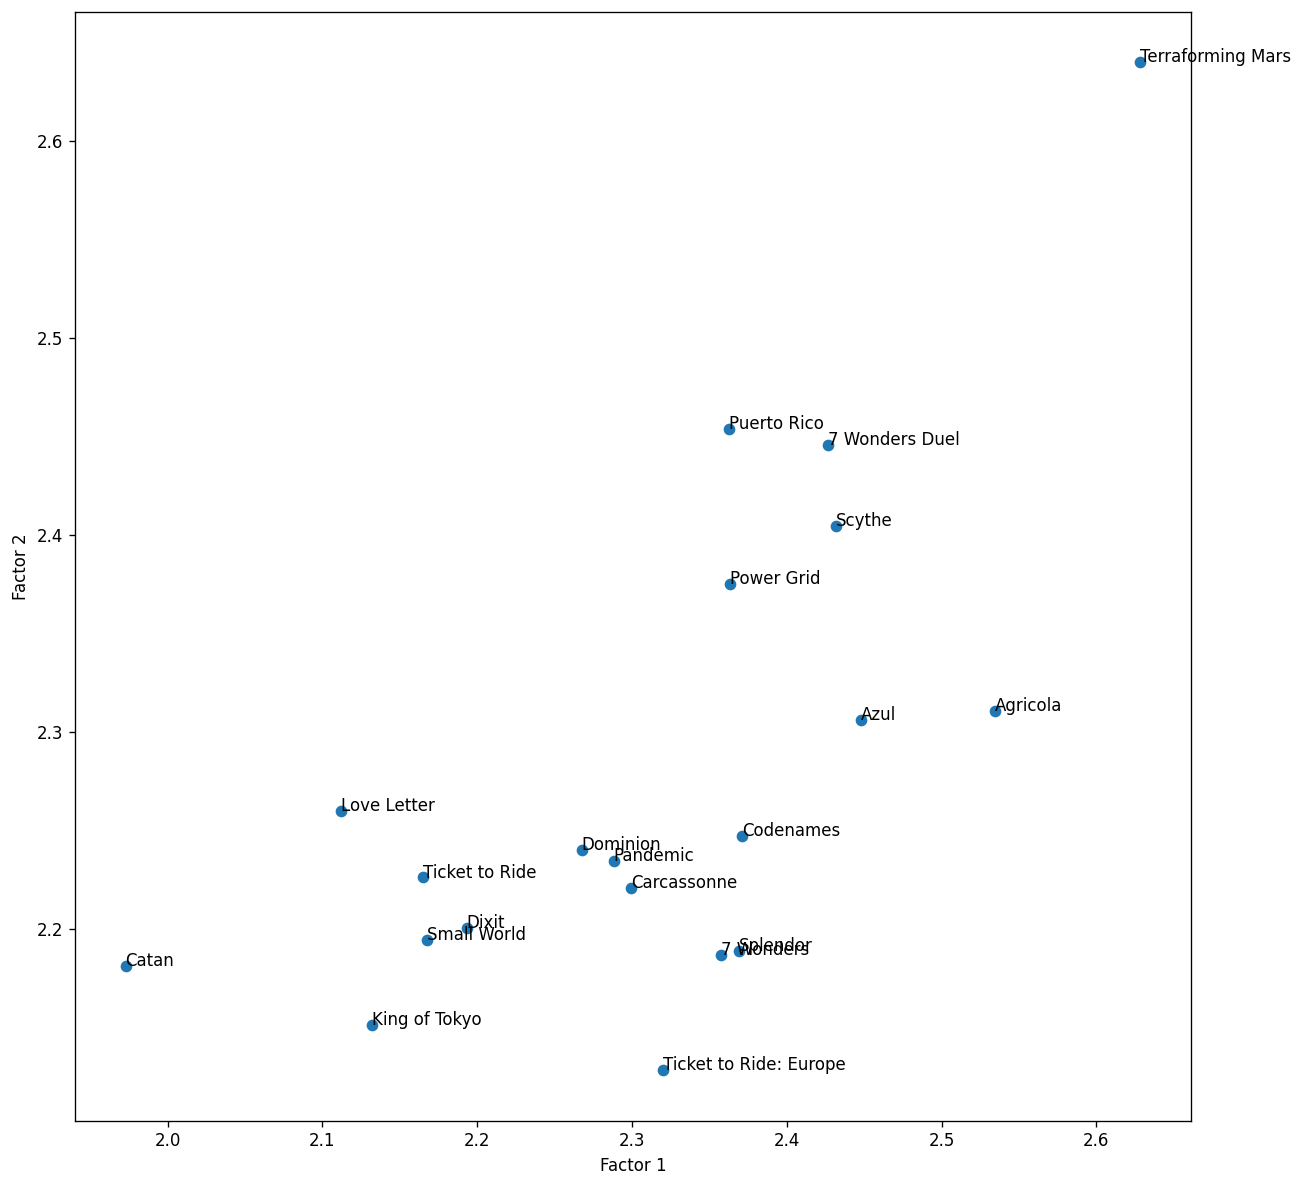

In [262]:
show_2d_plot(most_rated_game_ids(df, 20)) #, '20-most-rated_2d_plot')

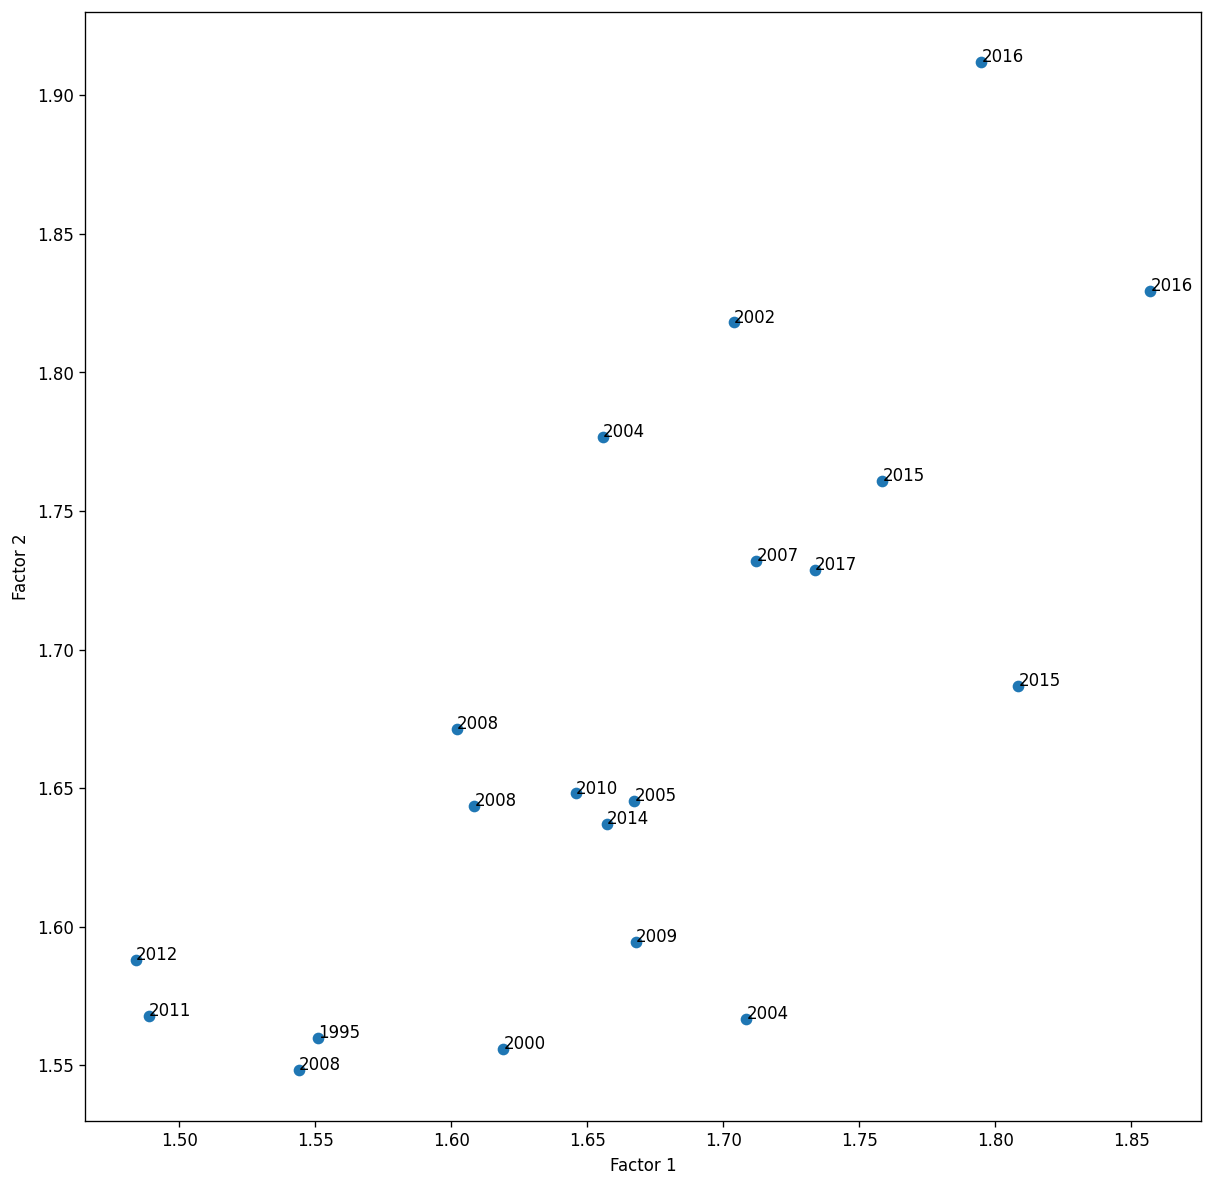

In [40]:
show_2d_plot(most_rated_game_ids(20), label='YearPublished') #, '20-most-rated_2d_plot')

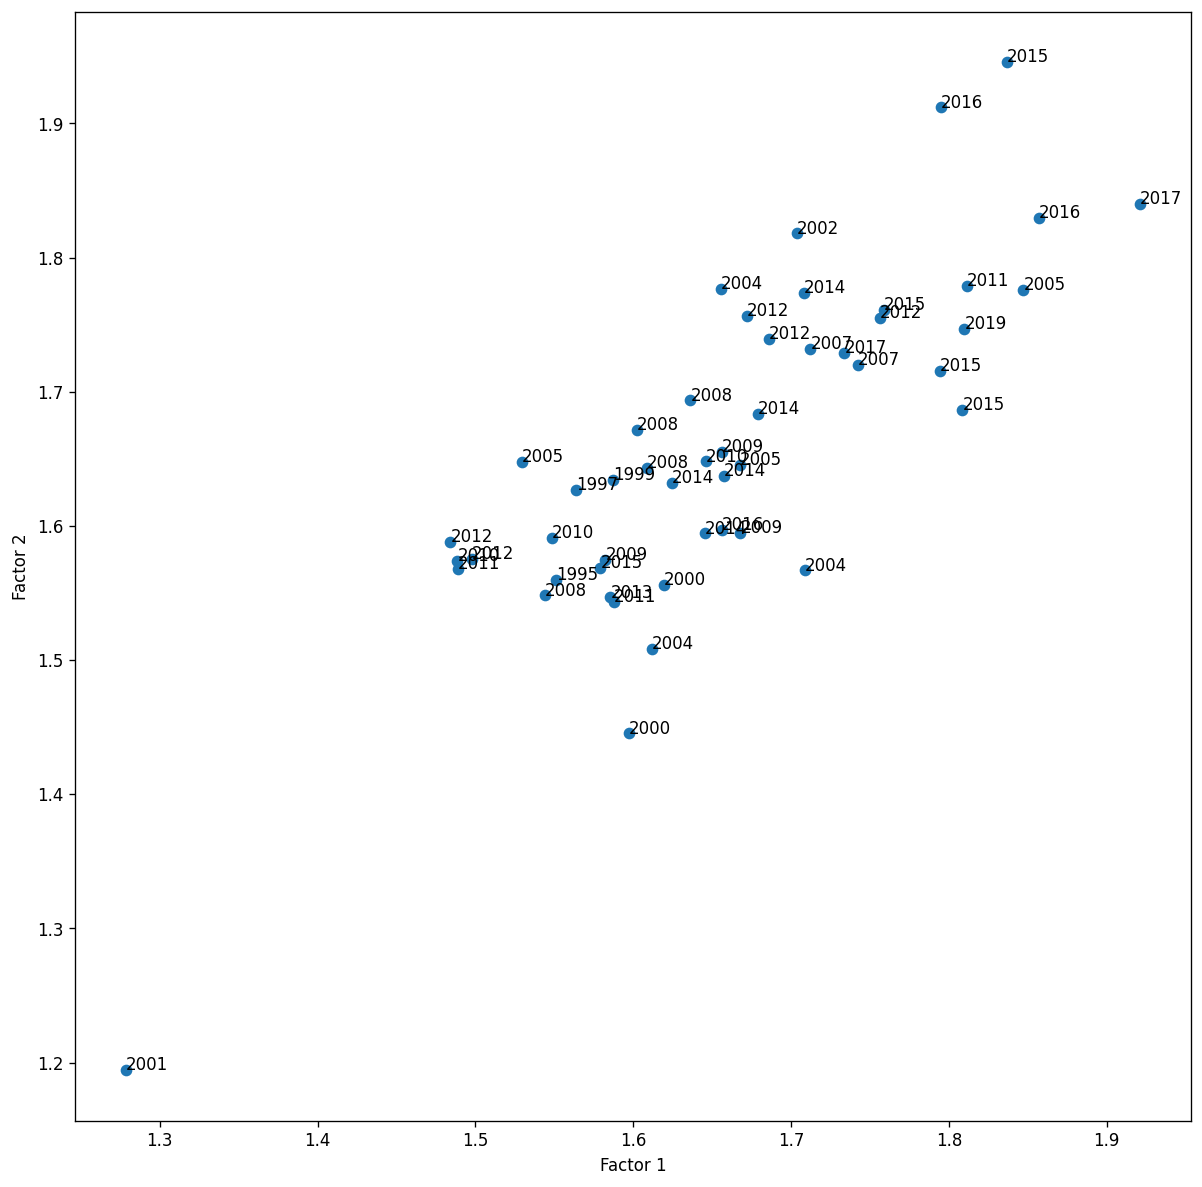

In [41]:
show_2d_plot(most_rated_game_ids(50), label='YearPublished')

In [154]:
def combine_ids(x, y):
    return np.unique(np.append(x, y))

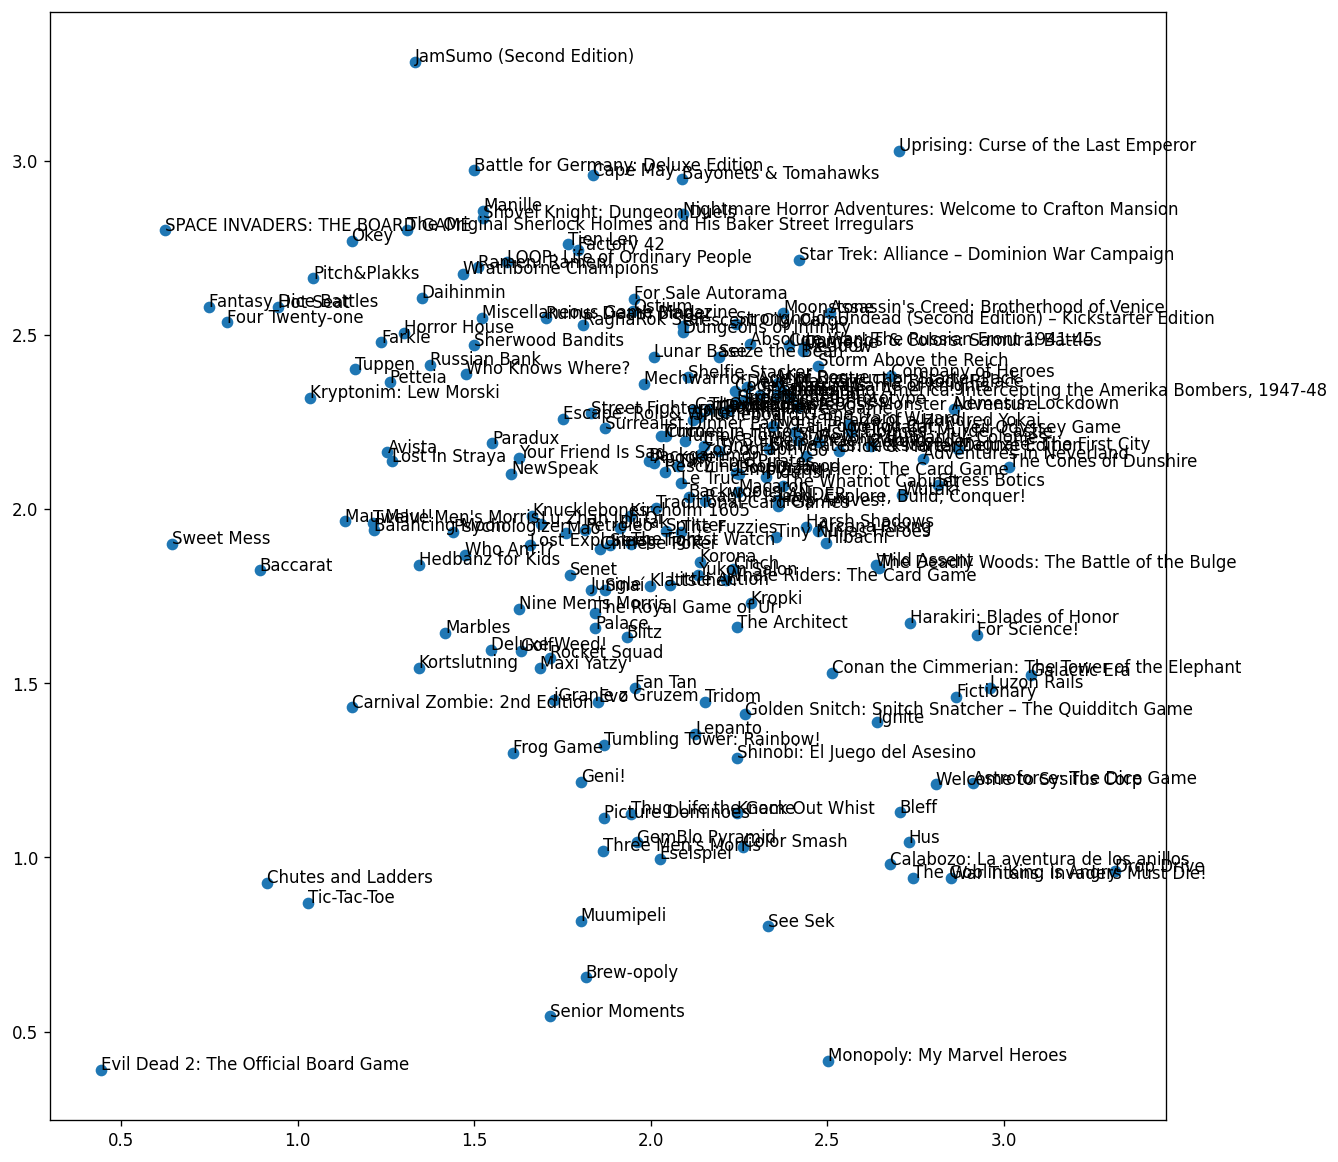

In [156]:
ids = combine_ids(oldest_game_ids(100), newest_game_ids(100))
# show_2d_plot(ids, label='YearPublished')
show_2d_plot(ids)

In [33]:
# global mean = mean across all training examples
# mean per user/item = mean across user/item's ratings
# global mean + user bias + item bias
#   - user/item bias = deviation from global mean = SUM(users_item_rating - mean_item_rating) for user's ratings

In [150]:
def compute_global_mean(df):
    return df[RATING].mean()

def global_mean_RMSE(train_df, test_df):
    mean = compute_global_mean(train_df)
    RMSE = sqrt(sum((test_df[RATING] - mean)**2)/len(test_df))
    return RMSE

def compute_mean_ratings(df, col):
    return df.groupby([col])[RATING].mean()

def local_mean_RMSE(train_df, test_df, mean_ratings, col):
    
#     mean_ratings = compute_mean_ratings(train_df, col)
    check_index = len(train_df) != len(test_df)
    global_mean = compute_global_mean(train_df)
    
    diffs = []
    i = 0
    cutoff = 100000
    c = 0
    c_max = len(test_df) // cutoff + 1
    for _, rating in test_df.iterrows():
        i += 1
        actual = rating[RATING]
        _id = rating[col]
        predicted = 0
        if check_index:
            predicted = mean_ratings.loc[_id] if _id in mean_ratings.index else global_mean
        else:
            predicted = mean_ratings.loc[_id]
        diff = actual - predicted
        diffs.append(diff)
        if i > cutoff:
            c += 1
            print(f'{c}/{c_max}')
            i = 0
        
    RMSE = sqrt(sum(np.array(diffs)**2)/len(diffs))
    return RMSE


def user_mean_RMSE(train_df, test_df, mean_ratings):
    return local_mean_RMSE(train_df, test_df, mean_ratings, USER)

def item_mean_RMSE(train_df, test_df, mean_ratings):
    return local_mean_RMSE(train_df, test_df, mean_ratings, ITEM)


def mean_with_biases_RMSE(train_df, test_df, item_biases, user_biases):
   
    global_mean = compute_global_mean(train_df)
    check_index = len(train_df) != len(test_df)
    
    diffs = []
    i = 0
    c = 0
    for _, rating in test_df.iterrows():
        i += 1
        actual = rating[RATING]
        user_id = rating[USER]
        item_id = rating[ITEM]
        if check_index:
            user_bias = user_biases.loc[user_id] if user_id in user_biases.index else 0
            item_bias = item_biases.loc[item_id] if item_id in item_biases.index else 0
        else:
            user_bias = user_biases.loc[user_id]
            item_bias = item_biases.loc[item_id]
        predicted = global_mean + user_bias + item_bias
        diff = actual - predicted
        diffs.append(diff)
        if i > 100000:
            c += 1
            print(c)
            i = 0
        
    RMSE = sqrt(sum(np.array(diffs)**2)/len(diffs))
    return RMSE


In [118]:
global_mean_RMSE(X_train, X_test)

1.5296761060552955

In [ ]:
# global_mean_RMSE(X_train, X_test)

# 1.5296761060552955

In [48]:
item_mean_ratings = compute_mean_ratings(X_train, ITEM)
user_mean_ratings = compute_mean_ratings(X_train, USER)

In [60]:
item_mean_ratings_all = compute_mean_ratings(df, ITEM)
user_mean_ratings_all = compute_mean_ratings(df, USER)

In [58]:
user_mean_RMSE(X_train, X_test, user_mean_ratings)

1.3759496736433414

In [42]:
user_mean_RMSE_all = user_mean_RMSE(df, df, user_mean_ratings_all)

In [69]:
user_mean_RMSE_all

1.3538852672920596

In [ ]:
# user_mean_RMSE(X_train, X_test, user_mean_ratings)
# 1.3759496736433414

In [59]:
item_mean_RMSE(X_train, X_test, item_mean_ratings)

1.3162866381367142

In [ ]:
item_mean_RMSE_all = item_mean_RMSE(df, df, item_mean_ratings_all)

In [ ]:
# item_mean_RMSE(X_train, X_test, item_mean_ratings)
# 1.3162866381367142

In [25]:
print(global_mean_RMSE(df, df))
print(global_mean_RMSE(X_train, X_test))

1.529492740231353
1.5296761060552955


In [103]:

# computes biases using the formula:
# user_bias = [ SUM(user_X_rating - item_Y_mean_rating) for each rating of user X ] - divided by number of ratings
def compute_biases(df, mean_ratings, col):
    unique_elements = df[col].unique()
    
    is_user_bias = col == USER
    
    biases = pd.DataFrame(
        index=unique_elements,
        data={'Bias': np.zeros(len(unique_elements)), 'Ratings_count': np.zeros(len(unique_elements))},
    )
    
    for _, rating in df.iterrows():
        item_id = rating[GAME]
        user_id = rating[USER]
        
        biases_id = user_id if is_user_bias else item_id
        mean_rating_id = item_id if is_user_bias else user_id
        
        actual = rating[RATING]
        bias = actual - mean_ratings.loc[mean_rating_id]
        biases.loc[biases_id]['Bias'] += bias
        biases.loc[biases_id]['Ratings_count'] += 1
            
    biases_computed = biases['Bias'] / biases['Ratings_count']
    return biases_computed


def compute_item_biases(df, item_mean_ratings):
    return compute_biases(df, item_mean_ratings, ITEM)


def compute_user_biases(df, user_mean_ratings):
    return compute_biases(df, user_mean_ratings, USER)

    

In [111]:
start = time.time()

user_biases = compute_user_biases(X_train, item_mean_ratings)

end = time.time()

print(f'{end - start} seconds')

1368.0948929786682 seconds


In [115]:
save_df(user_biases, 'user_biases_X_train', timestamp=False)

In [112]:
start = time.time()

item_biases = compute_item_biases(X_train, user_mean_ratings)

end = time.time()

print(f'{end - start} seconds')

1341.5161423683167 seconds


In [116]:
save_df(item_biases, 'item_biases_X_train', timestamp=False)

In [43]:
mean_with_biases_rmse = mean_with_biases_RMSE(X_train, X_test, item_biases, user_biases)

In [106]:
mean_with_biases_rmse

1.1233029535213659

In [114]:
mean_with_biases_rmse

1.185266728047179

In [ ]:
# mean_with_biases_rmse

# 1.185266728047179

In [ ]:
# RMSE overview (models trained using X_train, RMSE computed on X_test):
# global mean: 1.530
# user mean: 1.376
# item mean: 1.316
# global mean + item/user global bias: 1.230
# global mean + item/user bias: 1.185

# note: difference between global and 'normal' bias is in how it's calculated:
# global bias: item/user_mean_rating - global_mean_rating = item/user bias
# normal bias: SUM()

# latent factors: 1.19

In [ ]:
def compute_user_bias(ratings, item_mean_ratings):
    total_bias = 0
    for rating in ratings:
        item_id = rating[GAME]
        
        actual = rating[RATING]
        bias = actual - item_mean_ratings.loc[item_id]
        total_bias += bias
    return total_bias / len(ratings)


In [146]:
# only using the formula: item/user_mean_rating - global_mean_rating = item/user bias
def compute_biases_global(train_df, mean_ratings):
    global_mean = compute_global_mean(train_df)
    df = pd.DataFrame(index=mean_ratings.index, data={'mean_rating': mean_ratings.values})
    biases = df['mean_rating'] - global_mean
    biases.name = 'biases'
    return biases
    

In [128]:
item_biases_global = compute_biases_global(X_train, item_mean_ratings)

In [129]:
user_biases_global = compute_biases_global(X_train, user_mean_ratings)

In [44]:
mean_with_biases_global_rmse = mean_with_biases_RMSE(X_train, X_test, item_biases_global, user_biases_global)

In [138]:
mean_with_biases_global_rmse

1.22950792296573

In [ ]:
# mean_with_biases_global_rmse

# 1.22950792296573